In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
from sklearn.metrics import r2_score

### Описание датасета:

Id - идентификационный номер квартиры <br>
DistrictId - идентификационный номер района <br>
Rooms - количество комнат
Square - площадь<br>
LifeSquare - жилая площадь
<br>
KitchenSquare - площадь кухни
<br>
Floor - этаж
<br>
HouseFloor - количество этажей в доме
<br>
HouseYear - год постройки дома
<br>
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
<br>
Social_1, Social_2, Social_3 - социальные показатели местности
<br>
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
<br>
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
<br>
Price - цена квартиры

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

In [4]:
train_df.shape

(10000, 20)

In [5]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
train_df = train_df.set_index('Id')

In [7]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


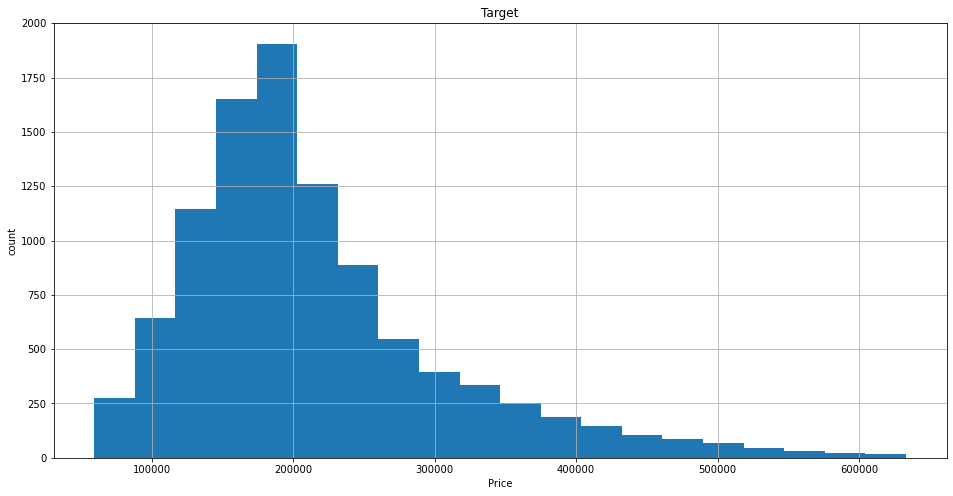

In [8]:
plt.figure(figsize = (16, 8))
plt.title('Target')
train_df['Price'].hist(bins=20)
plt.ylabel('count')
plt.xlabel('Price')
plt.show()

## Подготовка данных

In [9]:
def prepare_from_input(csvfile):
    df = pd.DataFrame(csvfile)
    df = df[((df['KitchenSquare'] + df['LifeSquare']) <= df['Square']) &
                   df['Rooms'] > 0] 
    df.loc[(df['KitchenSquare'] > df['LifeSquare']), 'KitchenSquare'] = df['LifeSquare']
    return df

train_df = prepare_from_input(train)

# train_df = train_df[(train_df['Rooms'] < train_df['Rooms'].quantile(.99)) & 
#                     (train_df['Rooms'] > train_df['Rooms'].quantile(.01)) &
#                     (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.95)) &
#                     (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.05))
#                    ]

In [10]:
def delete_rows(df):
    df = df.drop(df[df.KitchenSquare == 50].index)
    
    df = df.drop(df[df.HouseYear > 2020].index)
    
    df = df.drop(df[df.Floor > 30].index)
    df = df.drop(df[df.Floor == 0].index)
    
    df = df.drop(df[df.KitchenSquare < 5].index)
    
    df = df.drop(df[df.Ecology_1 == 0].index)
    df = df.drop(df[df.Social_1 == 0].index)
    df = df.drop(df[df.Social_3 == 0].index)
    df = df.drop(df[df.Helthcare_2 == 0].index)
    df = df.drop(df[df.Shops_1 == 0].index)
    return df

train_df = delete_rows(train_df)

In [11]:
def delete_small_kitchen(df):
    df = df.drop(df[(df['Rooms'] > 4) & (df['KitchenSquare'] < 7)].index)
    return df
    
train_df = delete_small_kitchen(train_df)

In [12]:
train_df.Price.describe()

count      3470.000000
mean     236425.447390
std       92182.151295
min       59174.778028
25%      174363.371818
50%      211626.701835
75%      282361.300419
max      625678.644994
Name: Price, dtype: float64

In [13]:
train_df.sort_values(by=['Price'], ascending=False).head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4764,11013,43,2.0,58.757047,34.605286,8.0,12,17.0,2004,0.000078,B,B,22,6398,141,1046.0,3,23,B,625678.644994
5494,300,31,2.0,106.427686,34.230415,32.0,4,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,624549.354546
4487,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.825328
6763,8479,32,4.0,115.734780,70.238395,10.0,6,24.0,2006,0.135650,B,B,46,7960,6,350.0,3,11,B,620399.280325
2442,13532,146,3.0,106.246398,64.451747,14.0,9,18.0,2010,0.236108,B,B,16,3893,27,NaN,3,10,B,616857.135464
3937,6808,146,3.0,106.867638,64.341756,14.0,4,22.0,2011,0.236108,B,B,16,3893,27,NaN,3,10,B,610557.405615
9699,4971,169,5.0,117.855969,76.561318,9.0,12,14.0,2001,0.178917,B,B,18,3594,4,192.0,1,5,B,608674.130507
3305,15749,66,3.0,78.747853,33.885760,11.0,2,5.0,1955,0.161976,B,A,31,7010,5,4508.0,3,7,B,606958.937510
507,10741,155,3.0,78.520750,45.130305,9.0,16,16.0,1989,0.042307,B,B,17,2810,9,4849.0,3,6,B,598541.346385
9712,11118,144,3.0,86.334911,51.875895,12.0,18,17.0,2004,0.306977,B,B,27,5148,14,1575.0,5,7,B,597921.009105


In [14]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,3470.000000,3470.000000,3470.000000,3470.000000,3470.000000,3470.000000,3470.000000,3470.000000,3470.000000,3.470000e+03,3470.000000,3470.000000,3470.000000,2341.000000,3470.000000,3470.000000,3470.000000
mean,8354.280115,67.463112,1.977522,54.078580,32.979971,7.707291,7.694813,12.154467,1981.506340,1.352207e-01,37.398271,8008.552450,9.012392,1329.412217,2.345245,6.521614,236425.447390
std,4832.828927,47.419762,0.846924,17.886181,12.295938,2.308754,4.734453,5.422565,16.875166,1.128437e-01,14.999198,3959.442773,18.548251,1143.357967,1.259887,4.239170,92182.151295
min,0.000000,0.000000,1.000000,25.410513,11.617853,5.000000,1.000000,1.000000,1912.000000,1.800000e-09,6.000000,1318.000000,1.000000,30.000000,1.000000,1.000000,59174.778028
25%,4238.250000,25.000000,1.000000,40.818898,22.652700,6.000000,4.000000,9.000000,1969.000000,4.111635e-02,25.000000,5048.000000,2.000000,320.000000,1.000000,4.000000,174363.371818
50%,8230.000000,61.000000,2.000000,49.392368,31.321600,8.000000,7.000000,12.000000,1978.000000,1.221905e-01,35.000000,7010.000000,4.000000,1130.000000,2.000000,5.000000,211626.701835
75%,12625.750000,99.000000,3.000000,62.782128,40.914066,9.000000,10.000000,16.000000,1996.000000,1.957811e-01,47.000000,10418.000000,8.000000,2078.000000,3.000000,9.000000,282361.300419
max,16798.000000,209.000000,10.000000,275.645284,233.949309,32.000000,28.000000,48.000000,2020.000000,4.605564e-01,74.000000,19083.000000,141.000000,4849.000000,5.000000,23.000000,625678.644994


In [15]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     1129
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [16]:
# mean = train_df['Healthcare_1'].mean()
# train_df['Healthcare_1'] = train_df['Healthcare_1'].fillna(mean)
# train_df.isnull().sum()

In [17]:
def replace_median(df):
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = 0
    df['Healthcare_1'].fillna(df['Healthcare_1'].median(), inplace=True)
    return df

train_df = replace_median(train_df)
test_df = replace_median(test_df)


### Обработка категориальных признаков

In [18]:
quantitative_cols = []
qualitative_columns = []

In [19]:
for col in qualitative_columns:
        print (col,'\n',train_df[col].value_counts(),'\n')

In [20]:
def replace_quantitives(df):
    global quantitative_cols
    global qualitative_columns
    quantitative_cols = [col for col in df.columns if df[col].dtype != 'object']
    qualitative_columns = [col for col in df.columns if df[col].dtype == 'object']
    quantitative_cols.remove('Id') # id квартиры - ненужный параметр
    
    df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0,'B':1})
    df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0,'B':1})
    df['Shops_2_bin'] = df['Shops_2'].replace({'A':0,'B':1})
    
    quantitative_cols = [col for col in train_df.columns if train_df[col].dtype != 'object']
    
    return df

train_df = replace_quantitives(train_df)

test_df = replace_quantitives(test_df)

In [21]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,1,1,1
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,4386,14,1130.0,1,5,B,296021.204377,1,1,1
13,2408,57,3.0,68.102739,39.311493,8.0,6,12.0,1980,0.133215,...,11395,3,1406.0,3,4,A,252481.908323,1,1,0
15,2823,85,3.0,73.612225,53.892089,6.0,4,9.0,1979,0.037178,...,11217,1,2300.0,1,7,B,89084.327876,1,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5f6941d60>,
      dtype=object)

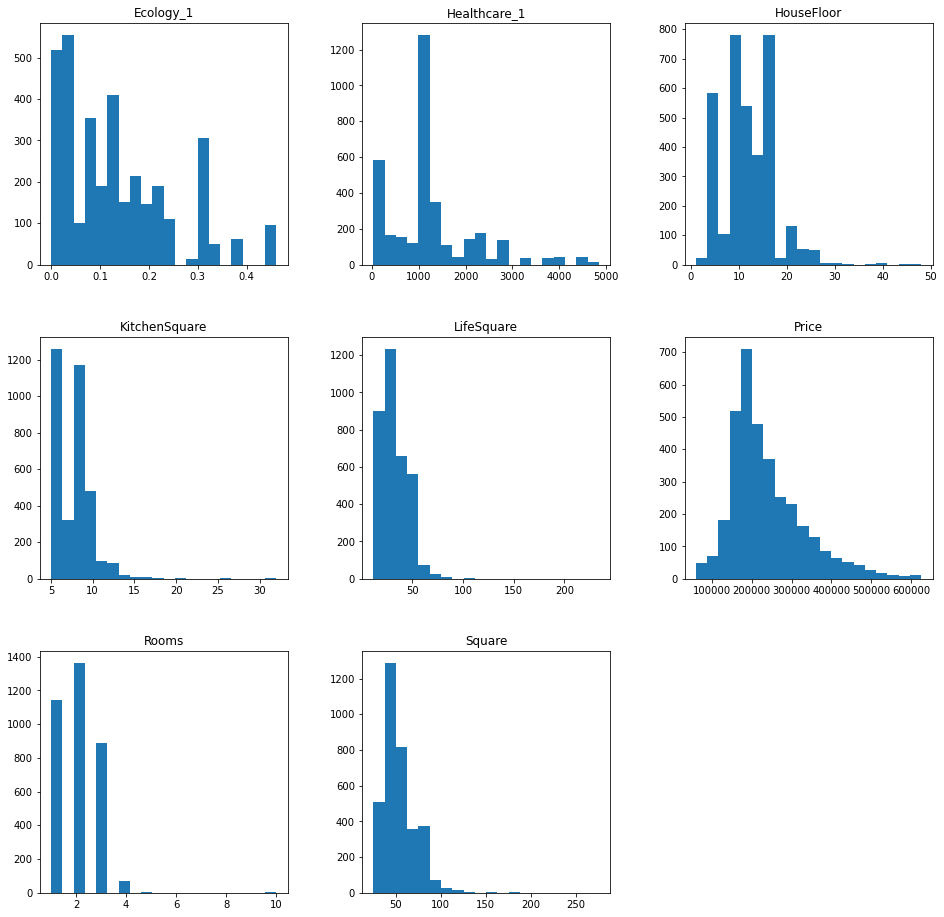

In [22]:
df_num_features = train_df.select_dtypes(include=['float64'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

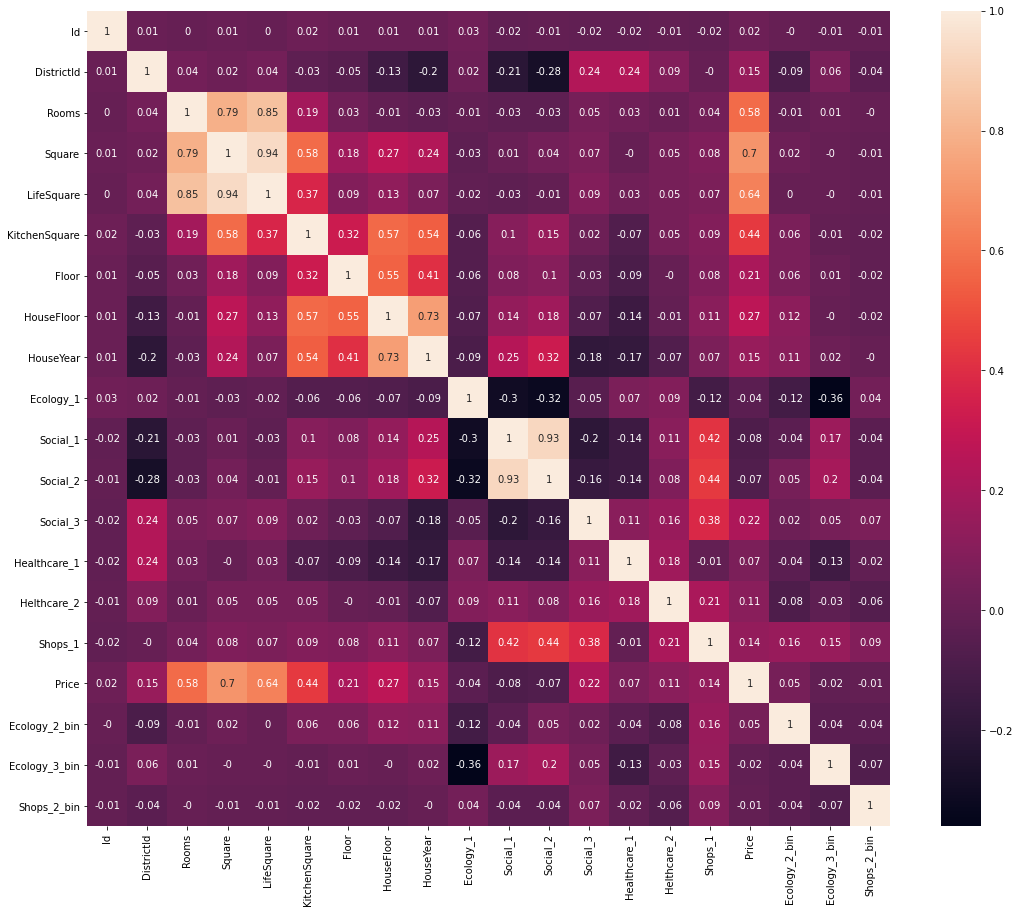

In [23]:
plt.figure(figsize = (18, 15))
correlation_matrix = train_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

## Тестирование моделей

In [24]:
y = train_df['Price']
X = train_df[quantitative_cols]
X = X.drop(columns=['Price'])

In [25]:
X

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,1,1,1
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,20,4386,14,1130.0,1,5,1,1,1
13,2408,57,3.0,68.102739,39.311493,8.0,6,12.0,1980,0.133215,49,11395,3,1406.0,3,4,1,1,0
15,2823,85,3.0,73.612225,53.892089,6.0,4,9.0,1979,0.037178,52,11217,1,2300.0,1,7,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,15233,1,3.0,57.373889,39.688445,5.0,2,5.0,1962,0.036270,6,1318,1,200.0,1,1,1,1,1
9992,14333,150,3.0,78.249637,49.385096,10.0,5,16.0,1976,0.300323,52,10311,6,1130.0,1,9,1,1,1
9993,48,13,3.0,80.631333,48.899083,10.0,11,14.0,1999,0.090799,74,19083,2,1130.0,5,15,1,1,1
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,46,7960,6,350.0,3,11,1,1,1


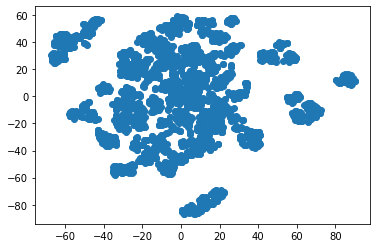

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(random_state=21)
tsne_representation = tsne.fit_transform(X_scaled)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1])

In [27]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle = True, random_state=42)

Train R2:	0.562
Test R2:	0.576


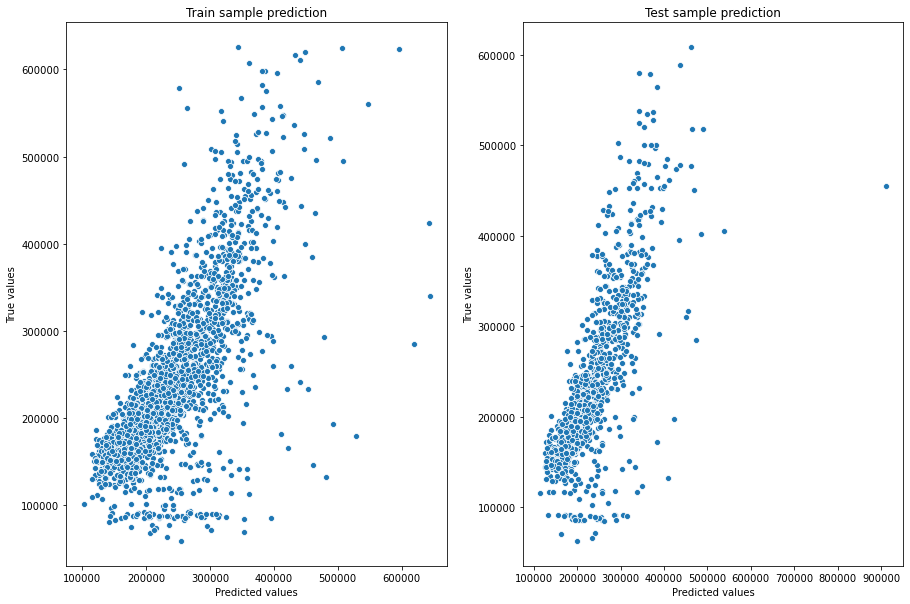

In [29]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Train R2:	0.562
Test R2:	0.576


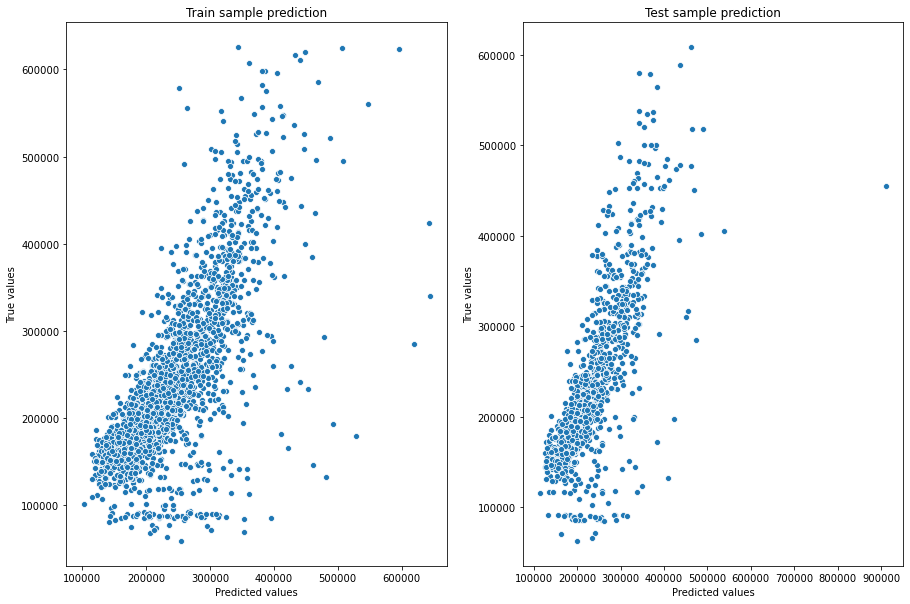

In [30]:
scaler = StandardScaler()

y_train_preds = scaler.fit_transform(X_train)
y_train_preds = pd.DataFrame(y_train_preds, columns=X_train.columns)

y_test_preds = scaler.transform(X_test)
y_test_preds = pd.DataFrame(y_test_preds, columns=X_test.columns)

lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Train R2:	0.782
Test R2:	0.645


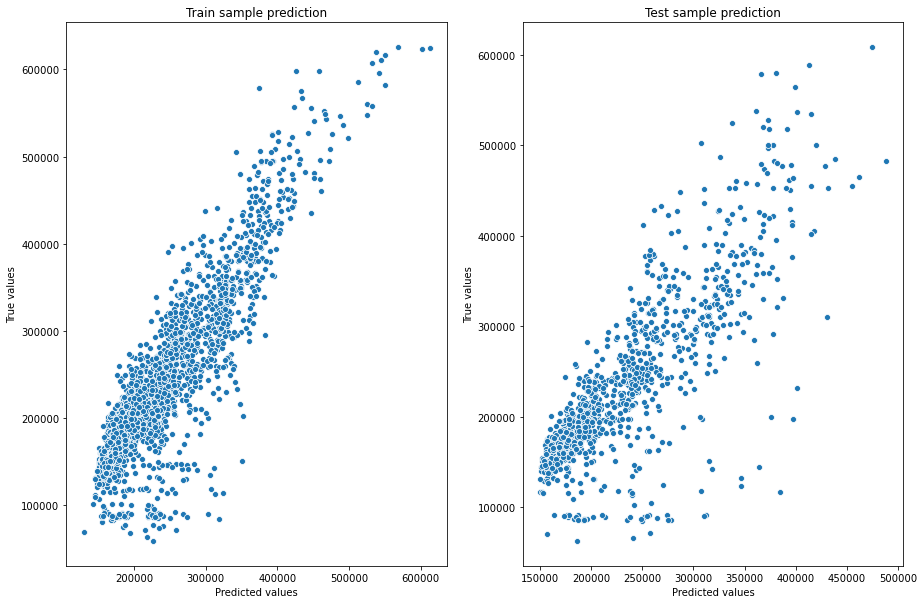

In [31]:
model_ExtraTrees = ExtraTreesRegressor(max_depth=8, random_state=42, n_estimators=1000)

model_ExtraTrees.fit(X_train, y_train)

y_train_preds = model_ExtraTrees.predict(X_train)
y_test_preds = model_ExtraTrees.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Train R2:	0.946
Test R2:	0.688


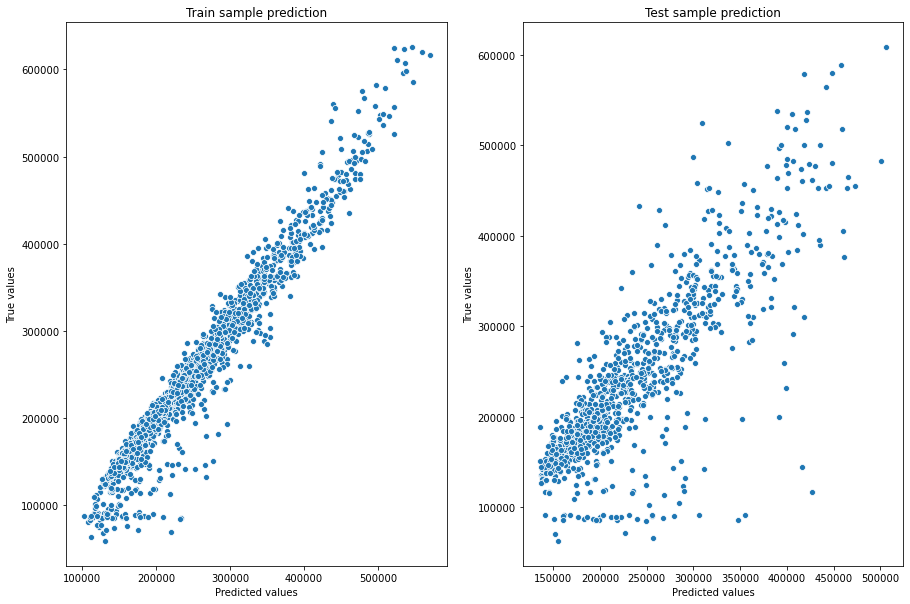

In [32]:
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Train R2:	0.909
Test R2:	0.701


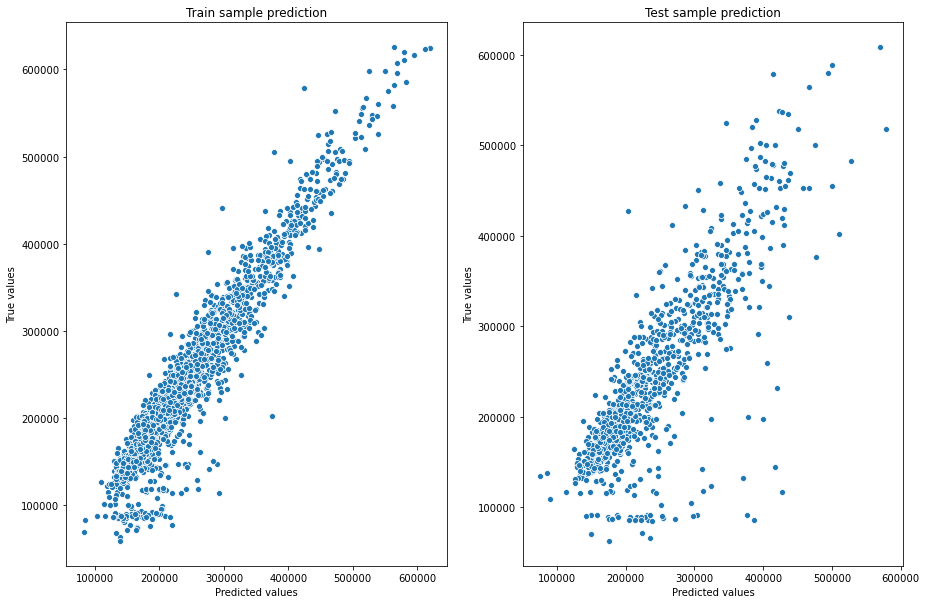

In [33]:
gbr_model = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_split=2, n_estimators=450)

gbr_model.fit(X_train, y_train)

y_train_preds = gbr_model.predict(X_train)
y_test_preds = gbr_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

## Save prediction

In [34]:
quantitative_cols.remove('Price')
X_test = test_df[quantitative_cols]

model = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_split=2, n_estimators=450)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

predict = pd.DataFrame()
predict['Id'] = X_test.index
predict['Price'] = y_pred

predict.to_csv('Kurnovskii_predictions.csv')

array([167422.417231  , 247907.0706644 ,  73889.69935892, ...,
       325071.38989003, 296698.06140992, 375998.21388609])

In [35]:
predict

,Id,Price
0,0,167422.417231
1,1,247907.070664
2,2,73889.699359
3,3,378673.563894
4,4,275534.770219
...,...,...
4995,4995,270500.502072
4996,4996,160200.537081
4997,4997,325071.389890
4998,4998,296698.061410


In [36]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,11,2748,1,900.0,0,0,B,1,1,1
1,15856,74,2.0,69.263183,0.000000,1.0,6,1.0,1977,0.075779,...,6,1437,3,900.0,0,2,B,1,1,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,30,7538,87,4702.0,5,5,B,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,900.0,3,3,B,1,1,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,2,629,1,900.0,0,0,A,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,36,5992,0,900.0,1,1,B,1,1,1
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,1,264,0,900.0,0,1,B,1,1,1
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,...,74,19083,2,900.0,5,15,B,1,1,1
4998,4780,62,2.0,81.305222,0.000000,0.0,4,0.0,1977,0.072158,...,2,629,1,900.0,0,0,A,1,1,0
